## Run a single example of the calibration for a certain set of parameters

In [1]:
include("ms_calibration.jl")

detuning_khz = 10
pi_time_blue_μs = 5
pi_time_red_μs = 7
sym_ac_stark_shift_khz = real_sym_ac_stark_shift_khz
antisym_ac_stark_shift_khz = real_antisym_ac_stark_shift_khz
θ = HamiltonianParameters([
    detuning_khz,
    pi_time_blue_μs,
    pi_time_red_μs,
    sym_ac_stark_shift_khz,
    antisym_ac_stark_shift_khz
])

HamiltonianParameters(10.0, 5.0, 7.0, 1.0, -0.035)

In [2]:
# demonstrate that we achieve >99.99% fidelity with ideal parameters
@time ms_fidelity(θ, θ)

 34.206878 seconds (83.52 M allocations: 4.272 GiB, 4.24% gc time)


0.9999675852337855

In [3]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

function rand_coeff()
    # returns a uniform random float in [0.9, 1.1]
    return 0.9 + (rand() * 0.2)
end

param_count = length(fieldnames(HamiltonianParameters))
initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])

N = 50
tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:200

@time res = ms_calibration(θ, initial_guess, N, tspan_ideal, tspan_experiment)

ideal_fit_params = as_vector(res["ideal_fit_params"])
learned_fit_params = as_vector(res["learned_fit_params"])
error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]

  7.421024 seconds (50.86 M allocations: 2.172 GiB, 5.77% gc time)


5-element Array{Float64,1}:
 -0.010867929591596947
  0.061549707696991085
  0.017610144304071262
  0.04772691560591258
 -0.07308281377449134

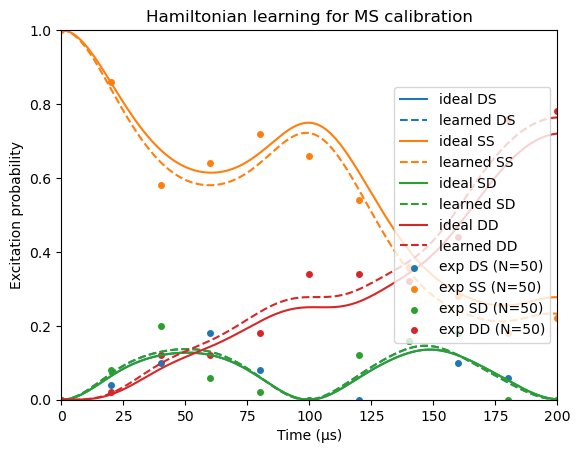

ideal fit parameters [10.0, 5.0, 7.0, 1.0, -0.035]
learned fit parameters [10.10867929591597, 4.692251461515045, 6.876728989871501, 0.9522730843940874, -0.0375578984821072]
fit parameters relative error=[-0.010867929591596947, 0.061549707696991085, 0.017610144304071262, 0.04772691560591258, -0.07308281377449134]


In [4]:
ideal = res["ideal_curve"]
learned = res["learned_curve"]
experimental = res["experimental_data"]

plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters $(ideal_fit_params)")
println("learned fit parameters $(learned_fit_params)")
println("fit parameters relative error=$(relative_error)")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [5]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000]

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        
        initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])        
        tspan_ideal = 0:0.1:200
        tspan_experiment = 20:20:200
        res = ms_calibration(θ, initial_guess, n_shots, tspan_ideal, tspan_experiment)

        ideal_fit_params = as_vector(res["ideal_fit_params"])
        learned_fit_params = as_vector(res["learned_fit_params"])
        error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
        relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        fidelity = ms_fidelity(θ, res["learned_fit_params"])
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!


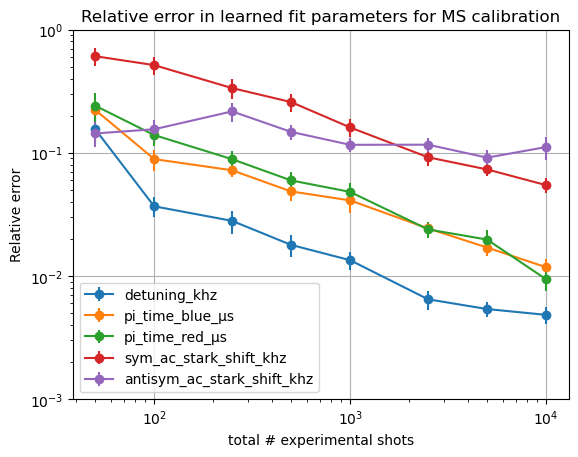

In [6]:
import PyPlot
const plt = PyPlot;
import Statistics

total_n_shots = [n_shots * length(tspan_experiment) for n_shots in n_shots_list]

plt.figure()

for (index, label) in enumerate(fieldnames(HamiltonianParameters))
    means = []
    stderrs = []
    for n_shots in n_shots_list
        relative_errors = [abs(errors[index]) for errors in relative_error_results[n_shots]]
        push!(means, mean(relative_errors))
        push!(stderrs, Statistics.std(relative_errors) / sqrt(length(relative_errors)))
    end
    plt.errorbar(x=total_n_shots, y=means, yerr=stderrs, linestyle="-", marker="o", label=label)
end

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-3, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Relative error")
plt.legend()
plt.grid();

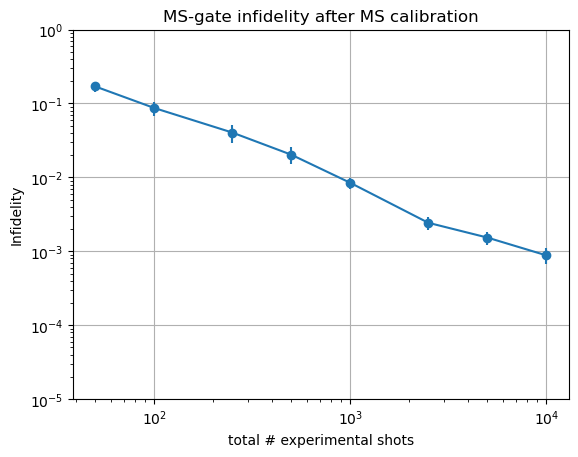

In [7]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure()
plt.errorbar(x=total_n_shots, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-5, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [8]:
print(relative_error_results)

Dict{Any,Any}(25 => Any[[-0.07393905096900114, 0.06246149224286466, 0.03888229020202021, 0.6535687418168087, 0.5257762441029602], [-0.007603951295247491, -0.10419051036004986, 0.13089519209405967, 0.24946716819988946, 0.2642124396602508], [0.04213311443209715, 0.0007839101493232192, 0.03326934839306946, -0.5217381196284874, -0.003755094005619487], [-0.022965417424092572, 0.03545370437925932, -0.0020744055761071473, 0.011842054770908828, 0.06056241063082172], [-0.00698305174107503, 0.0614963832172025, -0.10413564736980163, 0.32370498381173984, 0.04692723832240861], [0.010739659136681467, 0.0500706814939285, -0.13421146017242083, 0.11650126539874028, 0.2433811219715218], [-0.06502362923434664, 0.06715332788378384, -0.14987764701041403, 0.7756396911419653, 0.39440006252805254], [-0.03366362350109124, 0.07352813662969844, -0.0957423185195808, 0.24681344539998162, 0.36176027084244433], [-0.002962505335339749, 0.04749246540634822, -0.044670300054599946, 0.1447134978213226, 0.1610454327785332

, 0.027598252438151637], [-0.0103545682246045, -0.028497962551729296, 0.021447178259065884, 0.08393113003778985, -0.014151880083615056], [-0.005170243672620067, 0.011159088829958997, -0.004516521991206065, 0.09606345477917355, 0.12459804264105771], [0.004542392919574034, -0.003306745226463725, -0.0012439578928500339, -0.08621865934008155, 0.11823781721655484], [0.0066928165814642785, 0.02101448559913166, -0.04763986324514453, 0.12235102450959512, 0.03222082679156048], [0.003906721124086232, -0.02646956317960285, 0.009824780387140868, -0.07088284563939173, -0.019874258406711386], [0.005001893914219835, 0.006192624728531904, 0.00017300755174482724, -0.030043375764859936, -0.07239588922853217], [0.010996211213462814, -0.004156647717211648, -0.0013447466294872004, 0.032450087364991, 0.15306446046819103]],5 => Any[[0.05647338215308188, 0.19312178997043894, -0.29058318946535344, 0.9291200555099027, -0.02952383470993485], [-0.06899463203377607, 0.286276045778391, -0.2981647728662565, 1.744758

In [9]:
print(fidelities)

Dict{Any,Any}(25 => Any[0.901194548172801, 0.9554652973465535, 0.9343078808432465, 0.9964784337242338, 0.9903231825465123, 0.9937555151968251, 0.9051959168913972, 0.983129328478898, 0.9982017294931461, 0.9945242370038134, 0.9877661060172482, 0.9974608291628271, 0.792799156572051, 0.958576116451404, 0.9960400059802532, 0.9185556563997088, 0.9686025730679038, 0.9904924061919671, 0.9883188736110465, 0.9413722139878358],10 => Any[0.9811604587268368, 0.9118638169695673, 0.9815461621122348, 0.961668967381755, 0.9833662954076181, 0.9312450800736313, 0.915331858363592, 0.987973244786544, 0.7943217105901702, 0.8158400446799836, 0.6603528120122466, 0.9373945250177838, 0.9710987400871788, 0.9190264137671611, 0.7997360266885137, 0.8462663020337948, 0.9628511195527097, 0.9927332485272615, 0.9447851221130308, 0.967429210900606],50 => Any[0.964665782844469, 0.969472847412241, 0.9981262877580046, 0.978743631973356, 0.9983116654465032, 0.9829914201744131, 0.9888053661788111, 0.9939200696261484, 0.98682